## Setup

In [1]:
import re
# import shutil
import string

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers
# from keras import losses
# from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Unzip Train/Test Data

In [2]:
# with zipfile.ZipFile('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip', 'r') as zip_ref:
#     zip_ref.extractall('./train/')

# with zipfile.ZipFile('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip', 'r') as zip_ref:
#     zip_ref.extractall('./test/')

## Observe Training Data

In [3]:
# df = pd.read_table('./train/train.tsv')
df = pd.read_table('train.tsv')
df.shape

(156060, 4)

In [4]:
df.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [5]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
df['Sentiment'].unique()

array([1, 2, 3, 4, 0])

<Axes: xlabel='Sentiment', ylabel='Count'>

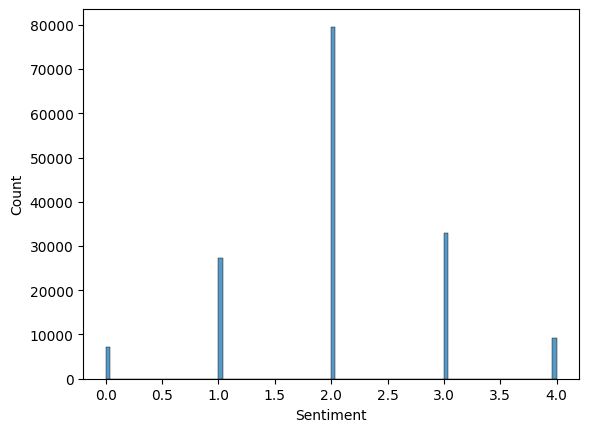

In [7]:
sns.histplot(df["Sentiment"])

## Convert Pandas DataFrame to TensorFlow Dataset

In [22]:
# text
phrases = df['Phrase'].dropna().values

# labels
# sentiments = df['Sentiment'].values
# num_classes = df['Sentiment'].nunique()
# labels = tf.one_hot(sentiments, depth=num_classes)
labels = df['Sentiment'].values

# combing text and label to form a dataset
dataset = tf.data.Dataset.from_tensor_slices((phrases, labels))

batch_size = 256
seed = 42

# train/validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed)
raw_train_ds = tf.data.Dataset.from_tensor_slices((train_df['Phrase'], train_df['Sentiment'])).batch(batch_size)
raw_val_ds = tf.data.Dataset.from_tensor_slices((val_df['Phrase'], val_df['Sentiment'])).batch(batch_size)


In [23]:
# have a look at some data
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'cheesy'
Label 1
Review b'unintentionally -RRB-'
Label 2
Review b"will need all the luck they can muster just figuring out who 's who in this pretentious mess"
Label 0


In [24]:
# have a look at some data in the validation dataset
for text_batch, label_batch in raw_val_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b"'s as sorry"
Label 2
Review b'Romantic comedy and Dogme 95 filmmaking may seem odd bedfellows , but they turn out to be delightfully compatible here'
Label 4
Review b'of these days'
Label 2


## Standardization

- to lower cases
- remove punctuations

In [25]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(
        lowercase, "[%s]" % re.escape(string.punctuation), " "
    )

In [26]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [27]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [28]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [29]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_text, first_label = text_batch[0], label_batch[0]
print("Text", first_text)
print("Label", first_label)
print("Vectorized text", vectorize_text(first_text, first_label))

Text tf.Tensor(b'cheesy', shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int64)
Vectorized text (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1694,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    

In [30]:
# retrieve a batch (of 32 reviews and labels) from the validation dataset
text_batch, label_batch = next(iter(raw_val_ds))
first_text, first_label = text_batch[0], label_batch[0]
print(text_batch.shape, label_batch.shape)
print("Text", first_text)
print("Label", first_label)
print("Vectorized text", vectorize_text(first_text, first_label))

(256,) (256,)
Text tf.Tensor(b"'s as sorry", shape=(), dtype=string)
Label tf.Tensor(2, shape=(), dtype=int64)
Vectorized text (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   7,   12, 3732,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          

In [31]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
# test_ds = raw_test_ds.map(vectorize_text)

In [32]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
embedding_dim = 32

model = tf.keras.Sequential(
    [
        layers.Embedding(max_features, embedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        layers.Dense(5),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 320165 (1.22 MB)
Trainable params: 320165 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [38]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # optimizer=tf.keras.optimizers.legacy.Adam(),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00005),
    metrics=['accuracy']
)

epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
488/488 [==============================] - 4s 7ms/step - loss: 0.7645 - accuracy: 0.6954 - val_loss: 0.9010 - val_accuracy: 0.6500
Epoch 2/10
488/488 [==============================] - 4s 7ms/step - loss: 0.7643 - accuracy: 0.6949 - val_loss: 0.9010 - val_accuracy: 0.6503
Epoch 3/10
488/488 [==============================] - 4s 7ms/step - loss: 0.7646 - accuracy: 0.6954 - val_loss: 0.9009 - val_accuracy: 0.6503
Epoch 4/10
488/488 [==============================] - 4s 7ms/step - loss: 0.7641 - accuracy: 0.6953 - val_loss: 0.9010 - val_accuracy: 0.6503
Epoch 5/10
488/488 [==============================] - 3s 7ms/step - loss: 0.7640 - accuracy: 0.6952 - val_loss: 0.9009 - val_accuracy: 0.6503
Epoch 6/10
488/488 [==============================] - 3s 7ms/step - loss: 0.7639 - accuracy: 0.6956 - val_loss: 0.9010 - val_accuracy: 0.6502
Epoch 7/10
488/488 [==============================] - 4s 7ms/step - loss: 0.7641 - accuracy: 0.6955 - val_loss: 0.9010 - val_accuracy: 0.6504
Epoch 

In [39]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

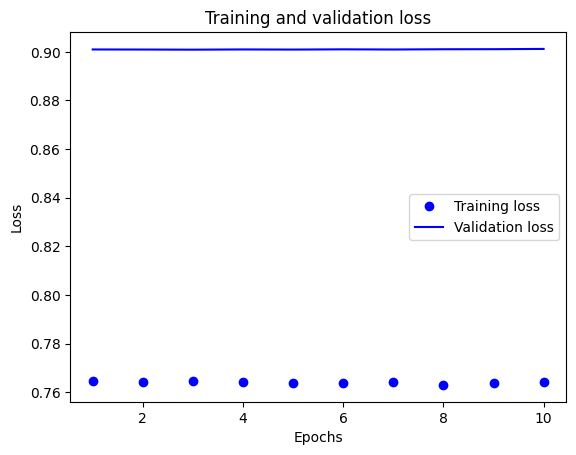

In [40]:
acc = history_dict["accuracy"]
val_acc = history_dict["accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, "bo", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

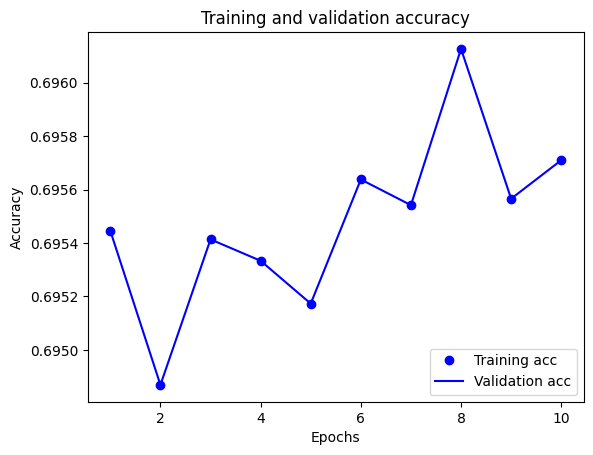

In [41]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()


In [42]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model, layers.Activation("sigmoid")]
)

export_model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"],
)

In [43]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible...",
    "I have mixed feelings. On the one hand, I enjoyed the open ending, but on the other hand, the plot was just fine.",
]

export_model.predict(examples)

1/1 [==============================] - 0s 56ms/step


array([[0.16084616, 0.4171026 , 0.5988506 , 0.6511154 , 0.45055178],
       [0.04616655, 0.38450715, 0.94617873, 0.56609464, 0.06934522],
       [0.72158694, 0.72754973, 0.749232  , 0.21203446, 0.08398543],
       [0.02260509, 0.42013696, 0.5154351 , 0.8975079 , 0.28348574]],
      dtype=float32)

In [44]:
dftest = pd.read_table('test.tsv')

preds = export_model.predict(dftest['Phrase'].astype(str).values)
predictions = np.array([np.argmax(p) for p in preds])

new_df = pd.DataFrame({'PhraseId': dftest['PhraseId'], 'Sentiment': predictions})
new_df.head()

new_df.to_csv("output.csv",index=False)

2072/2072 [==============================] - 2s 779us/step
